
<h1>User-based Collaborative Filtering using KNN</h1>

* Item based  
    * Let’s say one user buy item **P**.
    * Now, from all the user’s data, there’s one item **S** which users bought almost all time whenever item **P** get bought.
    * So, we recommend item **S** to users whenever they buy item **P**.
    * Logic behind this is, similar items may be sold together.  
<br>     
* User based
    * Let’s say we want to show recommendations to user **A**.
    * In this method, we try to find a similar user **B** who also tends to like items that user **A** likes.
    * So, we recommend user **B**‘s other liked items to user **A**.
    * Logic behind this is, similar people may like similar items.  



# Analysis preparation

In [9]:
import numpy as np
import pandas as pd
import re
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import matplotlib.pyplot as plt

### We have the following datasets

1. u.user - Contains information about the users
2. u.item - Contains information about the movies
3. u.genre - Contains information about the genres
4. u.data - Contains information about the ratings

## Read users data

In [10]:
user_columns = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users_df = pd.read_csv(r'..\datasets\ml-100k\u.user', sep='|', names=user_columns) 
users_df.head()

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


## Read movies data

In [11]:
genre_df = pd.read_csv(r'..\datasets\ml-100k\u.genre', sep='|', encoding='latin-1')
genre_columns = ["unknown"] + list(genre_df[genre_df.columns[0]].values)
print(genre_columns)

['unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [12]:
movie_columns = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies_df = pd.read_csv(r'..\datasets\ml-100k\u.item', sep='|', names=movie_columns+genre_columns,
                    encoding='latin-1')

movies_df.head(3)

,movie_id,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Because we are not building now a content-based recommender, we retain only `movie_id` and `title`.

In [13]:
movies_df = movies_df[["movie_id", "title"]]
movies_df.head(2)

,movie_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)


## Read ratings data

In [14]:
ratings_columns = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings_df = pd.read_csv(r'..\datasets\ml-100k\u.data', sep='\t', names=ratings_columns)
ratings_df.drop( "unix_timestamp", inplace = True, axis = 1 ) 
ratings_df.head(2)

,user_id,movie_id,rating
0,196,242,3
1,186,302,3


We merge now ratings with movie data.

In [15]:
rating_movies_df = ratings_df.merge(movies_df, how="outer")

In [16]:
print(rating_movies_df.shape)
rating_movies_df.head(2)

(100000, 4)


,user_id,movie_id,rating,title
0,196,242,3,Kolya (1996)
1,63,242,3,Kolya (1996)


## Calculate total rating movie


We will calculate now the total rating movie. We will only consider movies with a minimum rating factor, set conveniently so that we will not take into consideration movies that were only rated by a very small number of users.

In [17]:
movie_rating = rating_movies_df.dropna(axis = 0, subset = ["title"])
movie_rating_count = movie_rating.groupby(["title"])["rating"].count().reset_index().rename(columns = {'rating': 'total_rating_count'})
movie_rating_count.head()

,title,total_rating_count
0,'Til There Was You (1997),9
1,1-900 (1994),5
2,101 Dalmatians (1996),109
3,12 Angry Men (1957),125
4,187 (1997),41


### Merge total rating count to the movie ratings

In [18]:
rating_movies_df = rating_movies_df.merge(movie_rating_count, on="title", how="right")

In [19]:
rating_movies_df.head()

,user_id,movie_id,rating,title,total_rating_count
0,223,1300,1,'Til There Was You (1997),9
1,178,1300,3,'Til There Was You (1997),9
2,342,1300,1,'Til There Was You (1997),9
3,530,1300,2,'Til There Was You (1997),9
4,416,1300,3,'Til There Was You (1997),9


### Filter only movies with a number of ratings over a threshold

In [20]:
rating_movies_df.total_rating_count.describe()

count    100000.000000
mean        169.088380
std         122.187866
min           1.000000
25%          72.000000
50%         146.000000
75%         240.000000
max         583.000000
Name: total_rating_count, dtype: float64

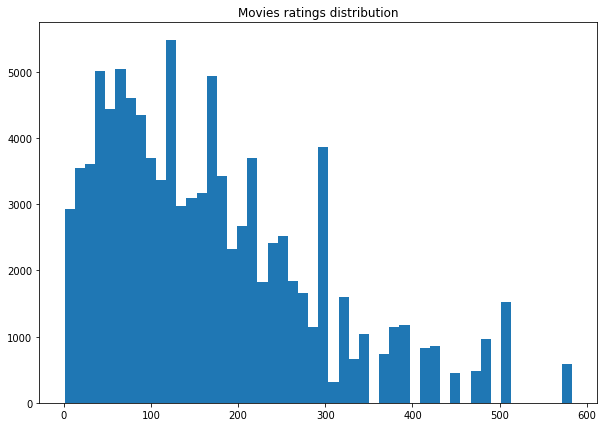

In [21]:
plt.figure(figsize=(10,7))
plt.hist(rating_movies_df.total_rating_count, bins=50) #bins is the number of bars
plt.title("Movies ratings distribution")
plt.show()

We will only consider moview with at least 50 ratings.

In [22]:
ratings_threshold = 50
rating_popular_movies_df = rating_movies_df.loc[rating_movies_df.total_rating_count >= ratings_threshold]
print(rating_popular_movies_df.shape)
rating_popular_movies_df.head()

(84069, 5)


,user_id,movie_id,rating,title,total_rating_count
14,5,225,2,101 Dalmatians (1996),109
15,243,225,3,101 Dalmatians (1996),109
16,200,225,4,101 Dalmatians (1996),109
17,280,225,4,101 Dalmatians (1996),109
18,1,225,2,101 Dalmatians (1996),109


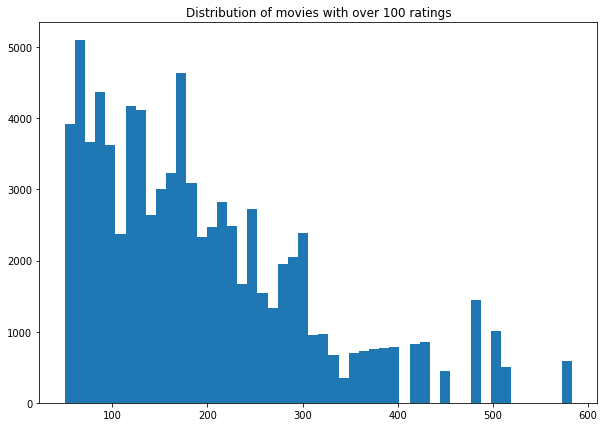

In [23]:
plt.figure(figsize=(10,7))
plt.hist(rating_popular_movies_df.total_rating_count, bins=50)
plt.title("Distribution of movies with over 100 ratings")
plt.show()

## Create pivot matrix (pivot table)

In [24]:
user_features_df = rating_popular_movies_df.pivot_table(index="user_id", columns="title", values="rating").fillna(0.0)
user_features_df.head()

title,101 Dalmatians (1996),12 Angry Men (1957),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),"39 Steps, The (1935)",Absolute Power (1997),"Abyss, The (1989)",Ace Ventura: Pet Detective (1994),Addams Family Values (1993),...,Willy Wonka and the Chocolate Factory (1971),Wings of Desire (1987),"Wings of the Dove, The (1997)",Winnie the Pooh and the Blustery Day (1968),"Wizard of Oz, The (1939)",Wolf (1994),"Wrong Trousers, The (1993)",Wyatt Earp (1994),Young Frankenstein (1974),Young Guns (1988)
user_id,,,,,,,,,,,,,,,,,,,,,
1,2.0,5.0,0.0,3.0,4.0,0.0,0.0,3.0,3.0,0.0,...,4.0,0.0,0.0,0.0,4.0,0.0,5.0,0.0,5.0,3.0
2,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,2.0,...,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,4.0,0.0


We create a sparse matrix from the original dataframe.
This will allow the following operations to be performed on a sparse matrix, i.e. faster (only non-zero values are included).

In [25]:
user_features_matrix = csr_matrix(user_features_df)

In [26]:
model_knn = NearestNeighbors(metric = "cosine", algorithm = "brute", n_neighbors = 20, n_jobs=-1)
model_knn.fit(user_features_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [27]:
user_features_df.shape

(943, 605)

In [28]:
user_features_df.head()

title,101 Dalmatians (1996),12 Angry Men (1957),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),"39 Steps, The (1935)",Absolute Power (1997),"Abyss, The (1989)",Ace Ventura: Pet Detective (1994),Addams Family Values (1993),...,Willy Wonka and the Chocolate Factory (1971),Wings of Desire (1987),"Wings of the Dove, The (1997)",Winnie the Pooh and the Blustery Day (1968),"Wizard of Oz, The (1939)",Wolf (1994),"Wrong Trousers, The (1993)",Wyatt Earp (1994),Young Frankenstein (1974),Young Guns (1988)
user_id,,,,,,,,,,,,,,,,,,,,,
1,2.0,5.0,0.0,3.0,4.0,0.0,0.0,3.0,3.0,0.0,...,4.0,0.0,0.0,0.0,4.0,0.0,5.0,0.0,5.0,3.0
2,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,2.0,...,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,4.0,0.0


## Test the recommendation

Select one user.

In [29]:
query_index = np.random.choice(user_features_df.shape[0])
print(query_index)

855


Use the model fit to get the closest movies

In [30]:
distances, indices = model_knn.kneighbors(user_features_df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)
print(distances, indices)

[[2.22044605e-16 3.15945732e-01 3.20864243e-01 3.32986558e-01
  3.48163321e-01 3.51208884e-01]] [[855 111 355  99 645 615]]


In [31]:
user_ids = []
for index in range(0, len(distances.flatten())+1):
    user_ids.append(user_features_df.index[indices.flatten()[index-1]])
    if index == 0: # the movie chosen
        print(f"Users similar with user having user_id:  {user_features_df.index[query_index]}")
        print("---------------------------------------------------------")
    else:
        print(f"{index-1}: {user_features_df.index[indices.flatten()[index-1]]} (dist: {distances.flatten()[index-1]})")

Users similar with user having user_id:  856
---------------------------------------------------------
0: 856 (dist: 2.220446049250313e-16)
1: 112 (dist: 0.3159457318314658)
2: 356 (dist: 0.3208642430855845)
3: 100 (dist: 0.3329865576701586)
4: 646 (dist: 0.34816332070832035)
5: 616 (dist: 0.35120888419470775)


In [32]:
print(user_ids)

[616, 856, 112, 356, 100, 646, 616]


These users are similar to the current user selected. For this user, we will recommend movies that were ranked by the users similar to him.

In [41]:
# select movies that were highly ranked by the most similar users.

# look only for movies highly rated by the similar users, not the current user
candidate_user_ids = user_ids[1:]
sel_ratings = rating_popular_movies_df.loc[rating_popular_movies_df.user_id.isin(candidate_user_ids)]

# sort by best ratings and total rating count
sel_ratings = sel_ratings.sort_values(by=["rating", "total_rating_count"], ascending=False)

# eliminate from the selection movies that were ranked already by the current user
movies_rated_by_targeted_user = list(rating_popular_movies_df.loc[rating_popular_movies_df.user_id==user_ids[0]]["movie_id"].values)
sel_ratings = sel_ratings.loc[~sel_ratings.movie_id.isin(movies_rated_by_targeted_user)]
# print(sel_ratings.head())

# aggregate and count total ratings and total total_rating_count
agg_sel_ratings = sel_ratings.groupby(["title", "rating"])["total_rating_count"].max().reset_index()
agg_sel_ratings.columns = ["title", "rating", "total_ratings"]
agg_sel_ratings = agg_sel_ratings.sort_values(by=["rating", "total_ratings"], ascending=False)
# print(agg_sel_ratings.head(5))

# only select top n (default top 10 here)
rec_list = agg_sel_ratings["title"].head(10).values
print(f"\nMovies recommended to user: {indices[0][0]}\n---------------------------------")
for i, rec in enumerate(rec_list):
    print(f"{i+1}: {rec}")


Movies recommended to user: 855
---------------------------------
1: Mrs. Brown (Her Majesty, Mrs. Brown) (1997)
2: Midnight in the Garden of Good and Evil (1997)
3: Eve's Bayou (1997)
4: Liar Liar (1997)
5: Tomorrow Never Dies (1997)
6: Seven Years in Tibet (1997)
7: Rainmaker, The (1997)
8: Kiss the Girls (1997)
9: Postman, The (1997)
10: Red Corner (1997)


Packing this in a recommendation function.

In [42]:
def recommend(user_id=10, n_users=5):

    distances, indices = model_knn.kneighbors(user_features_df.loc[user_features_df.index==user_id].values.reshape(1, -1), n_neighbors = n_users + 1)
    user_ids = []
    for index in range(0, len(distances.flatten())):
        user_ids.append(user_features_df.index[indices.flatten()[index]])
        if index == 0: # the movie chosen
            print(f"Users similar with user having user_id: {user_id}")
            print("---------------------------------------------------------")
        else:
            print(f"{index}: {user_features_df.index[indices.flatten()[index]]} (dist: {distances.flatten()[index]})")

    # select movies that were highly ranked by the most similar users.

    # look only for movies highly rated by the similar users, not the current user
    candidate_user_ids = user_ids[1:]
    sel_ratings = rating_popular_movies_df.loc[rating_popular_movies_df.user_id.isin(candidate_user_ids)]

    # sort by best ratings and total rating count
    sel_ratings = sel_ratings.sort_values(by=["rating", "total_rating_count"], ascending=False)

    # eliminate from the selection movies that were ranked already by the current user
    movies_rated_by_targeted_user = list(rating_popular_movies_df.loc[rating_popular_movies_df.user_id==user_ids[0]]["movie_id"].values)
    sel_ratings = sel_ratings.loc[~sel_ratings.movie_id.isin(movies_rated_by_targeted_user)]

    # aggregate and count total ratings and total total_rating_count
    agg_sel_ratings = sel_ratings.groupby(["title", "rating"])["total_rating_count"].max().reset_index()
    agg_sel_ratings.columns = ["title", "rating", "total_ratings"]
    agg_sel_ratings = agg_sel_ratings.sort_values(by=["rating", "total_ratings"], ascending=False)
    
    # only select top n (default top 10 here)
    rec_list = agg_sel_ratings["title"].head(10).values
    print(f"\nMovies recommended to user_id: {user_ids[0]}\n---------------------------------")
    for i, rec in enumerate(rec_list):
        print(f"{i+1}: {rec}")

In [43]:
recommend(10, 5)

Users similar with user having user_id: 10
---------------------------------------------------------
1: 234 (dist: 0.37382107196580316)
2: 537 (dist: 0.40290351988110495)
3: 474 (dist: 0.4032779366336642)
4: 6 (dist: 0.40430878000573434)
5: 308 (dist: 0.4097895728230926)

Movies recommended to user_id: 10
---------------------------------
1: Return of the Jedi (1983)
2: Empire Strikes Back, The (1980)
3: Fugitive, The (1993)
4: Indiana Jones and the Last Crusade (1989)
5: Princess Bride, The (1987)
6: E.T. the Extra-Terrestrial (1982)
7: Schindler's List (1993)
8: Birdcage, The (1996)
9: Mr. Holland's Opus (1995)
10: Blade Runner (1982)


In [36]:
recommend(42, 5)

Users similar with user having user_id: 42
---------------------------------------------------------
1: 577 (dist: 0.3958676193727865)
2: 311 (dist: 0.40028709528715156)
3: 864 (dist: 0.402753494720138)
4: 749 (dist: 0.4169928025552443)
5: 378 (dist: 0.4177061202735576)

Movies recommended to user_id: 42
---------------------------------
1: Contact (1997)
2: Fargo (1996)
3: English Patient, The (1996)
4: Scream (1996)
5: Pulp Fiction (1994)
6: Twelve Monkeys (1995)
7: Titanic (1997)
8: Dead Man Walking (1995)
9: Braveheart (1995)
10: L.A. Confidential (1997)


In [44]:
recommend(314, 5)

Users similar with user having user_id: 314
---------------------------------------------------------
1: 393 (dist: 0.4401651039456249)
2: 222 (dist: 0.4568145448058286)
3: 416 (dist: 0.4626341034314684)
4: 130 (dist: 0.46824745777266696)
5: 682 (dist: 0.47293188005667464)

Movies recommended to user_id: 314
---------------------------------
1: Star Wars (1977)
2: Contact (1997)
3: Fargo (1996)
4: Return of the Jedi (1983)
5: English Patient, The (1996)
6: Air Force One (1997)
7: Raiders of the Lost Ark (1981)
8: Godfather, The (1972)
9: Silence of the Lambs, The (1991)
10: Empire Strikes Back, The (1980)
